## Pré-Processamento

Para realizar o treinamento desse modelo de análise de sentimentos, foram utilizadas as seguintes bibliotecas:

- **Matplotlib/Seaborn:** Para avalização e visualização dos resultados.
- **Pandas:** Para manipulação e análise dos dados.
- **zipfile:** Para descomprimir o arquivo correspondente ao datset.
- **Scikit-learn:** Biblioteca com ampla funções úteis na ciência de dados, estatística e matemática em geral.
   - **TfidfVectorizer:** Para a conversão dos textos em uma forma numérica utilizável pelo modelo.
   - **Naive Bayes:** Como modelo de treinmmento, especificamente o modelo **MultinomialNB** usado em dados discretos.
   - **Pipeline**: Criar o fluxo de pré-processamento e treinamento.
   - **Metrics**: Apresenta as métricas de avaliação do modelo.
   - **train_test_split**: Divide o dataset em treino e teste.

In [40]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import zipfile

Estrututura de diretório:

- ├── sentiment labelled sentences/
- │     ├── amazon_cells_labelled.txt
- │     ├── imdb_labelled.txt
- │     ├── yelp_labelled.txt

O três arquivos .txt contendo os comentários que serão utilizados para teste e treinamento são juntos em um mesmo dataframe com as seguintes características: 

  

In [41]:
zip_file_path = 'sentiment+labelled+sentences.zip'
#Desconpata o arquivo para o ambiente de desenvolvimento.
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# 
amazon = pd.read_csv("sentiment labelled sentences/amazon_cells_labelled.txt", delimiter="\t", header=None, names=["sentence", "sentiment"])
imdb = pd.read_csv("sentiment labelled sentences/imdb_labelled.txt", delimiter="\t", header=None, names=["sentence", "sentiment"])
yelp = pd.read_csv("sentiment labelled sentences/yelp_labelled.txt", delimiter="\t", header=None, names=["sentence", "sentiment"])

df = pd.concat([imdb, yelp, amazon], ignore_index=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   2748 non-null   object
 1   sentiment  2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


,sentence,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


No treinamento de um modelo de linguagem natural, é importante adequar o texto ao processo, isso envolve transformar o texto em um vetor numérico, retirar palavras irrelevantes e ignorar palavaras muito comunm. Para esse pré-processamento foi utilizado a ferramenta **TfidfVectorizer** do **scikit-learn**, que usa o méto TF-IDF para calcular a importância de cada palavra no texto, com os seguintes parâmetros:

    lowercase = True: Converte todo texto em letras minúsculas.
    stop_words = 'english': Remove stop words automaticamente. 
    max_features=1000: Limita o número de features (termos) aos 1000 mais frequentes.
    ngram_range=(1, 2): Considera unigramas e bigramas.
    min_df=2: Ignora termos que aparecem em menos de 2 documentos.
    max_df=0.85: Ignora termos que aparecem em mais de 85% dos documentos.



In [42]:
tfidf = TfidfVectorizer(
    lowercase=True, 
    stop_words= 'english',
    max_features=1000,
    ngram_range=(1, 2), 
    min_df=2,  
    max_df=0.90  
)


# Ajusta o vetorizador aos dados e transforma os textos em vetores TF-IDF
vetores_tfidf = tfidf.fit_transform(df['sentence'])

# Exibe a matriz TF-IDF
print(vetores_tfidf.toarray())

# Exibe os termos (palavras) que foram vetorizados
print(tfidf.get_feature_names_out())



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['10' '10 10' '10 minutes' '12' '20' '30' '30 minutes' '40' '50' '90'
 'ability' 'able' 'absolutely' 'acting' 'acting bad' 'action' 'actor'
 'actors' 'actually' 'addition' 'adorable' 'advise' 'age' 'ago' 'amazing'
 'amazon' 'ambiance' 'annoying' 'anytime' 'anytime soon' 'appealing'
 'appearance' 'appreciate' 'area' 'aren' 'arrived' 'art' 'ask' 'asked'
 'atmosphere' 'attempt' 'attention' 'attentive' 'audience' 'audio'
 'audio quality' 'authentic' 'average' 'avoid' 'away' 'awesome' 'awful'
 'bacon' 'bad' 'bad film' 'bad food' 'bar' 'barely' 'bargain' 'bars'
 'basically' 'battery' 'battery life' 'bay' 'beat' 'beautiful' 'beef'
 'beer' 'beginning' 'believable' 'believe' 'belt' 'best' 'better' 'big'
 'bit' 'black' 'black white' 'bland' 'blue' 'bluetooth'
 'bluetooth headset' 'book' 'bored' 'boring' 'bother' 'bought' 'boyfriend'
 'bread' 

## Treinamento

Naive Bayes, modelo escolhido para análise, é um método de classificação que descreve a probabilidade de um evento, baseado no conhecimento prévio das condições relacionadas ao evento. É um modelo que lida muito com dados bem discretos, como a matriz de frequência de palavras gerada pelo TF-IDF.

O modelo funcionana calculando a probabilidade da mensagem ser positiva ou negativa com base nas palavras presentes e suas probabilidades condicionais, classificando-a na categoria com maior probabilidade.

In [43]:
# Cria o pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),  # Transforma texto em vetores TF-IDF.
    ('clf', MultinomialNB())  # Evoca o classificador Naive Bayes MultinomialNB.
])
X = df[['sentence']] 
y = df['sentiment']   

# Divida em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X['sentence'], y, test_size=0.2, random_state=42)

## Avaliação

In [44]:
# Treinando o pipeline
pipeline.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = pipeline.predict(X_test)

Accuracy: 0.7745454545454545
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       299
           1       0.71      0.84      0.77       251

    accuracy                           0.77       550
   macro avg       0.78      0.78      0.77       550
weighted avg       0.79      0.77      0.77       550



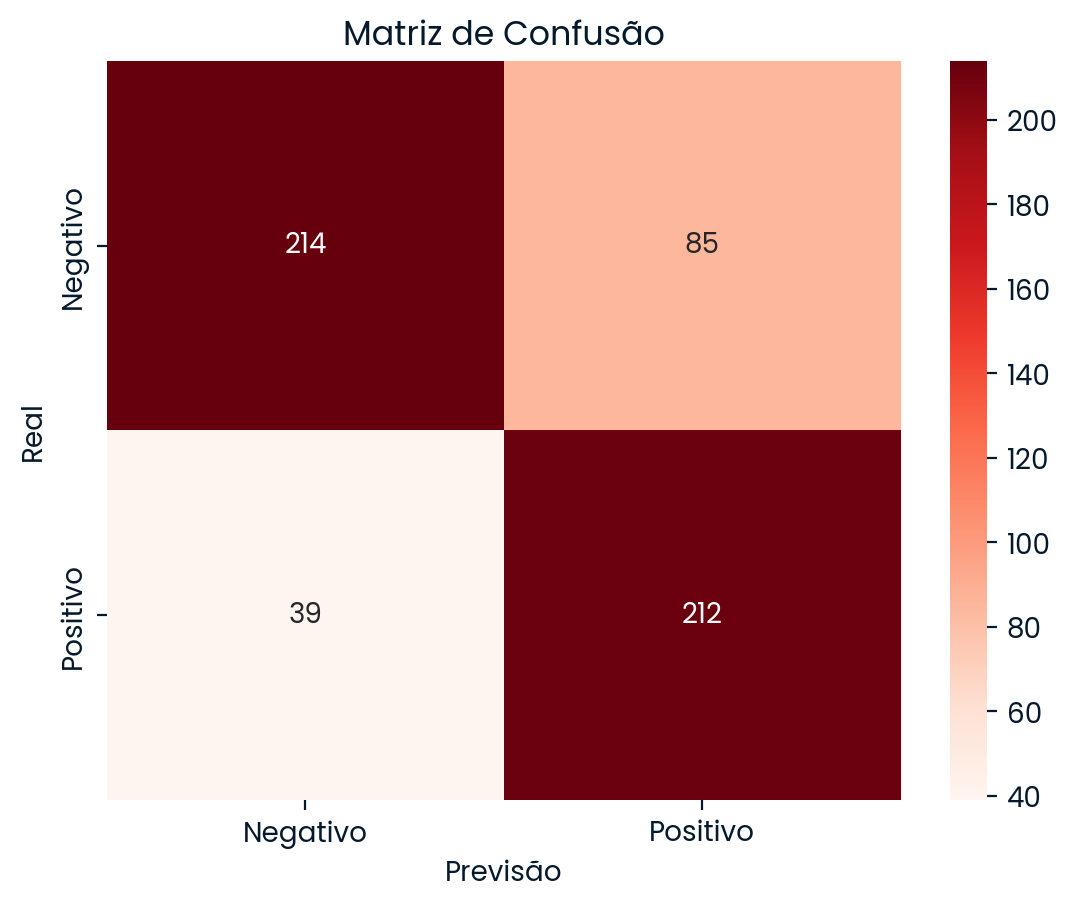

In [45]:
# Avalinhando o desempenho
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Conclusão

Os resultados do teste de desempenho indicam que o modelo está equilibrado, com uma performance sólida em termos de precisão e recall. A acurácia de 77%, mostra um que o modelo está sendo capaz de classificar as mensagens de forma correta na maioria das vezes.

Ele tem um desempenho particularmente bom na identificação de sentimentos negativos, mas ainda apresenta uma leve queda de desempenho na detecção de sentimentos positivos, refletido na diferença de precisão e recall entre as classes.

A fim de melhorar a eficácia do modelo, pode ser considerado ajuste dos hiperparmetros e implementação de validação cruzada.